In [3]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

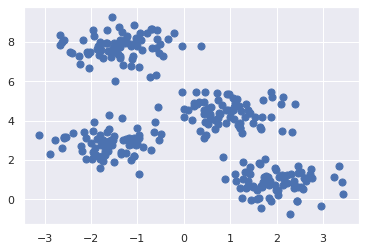

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

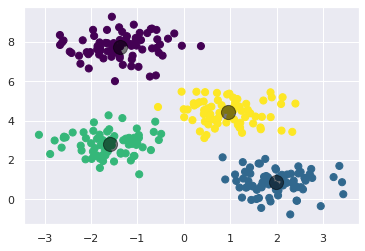

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# choosing n clusters

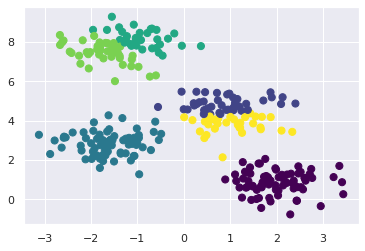

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

K-means вычесляет то количество кластеров, которое мы хотим вычислить, для того, чтоб определить оптимальное количество кластеров можно воспользоаться - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

# Non linear dependenses

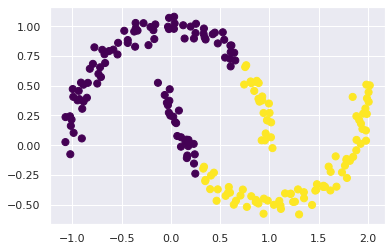

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

K-means в базовой вариации не очень хорошо справляется со сложными нелинейными разделениями кластеров

/home/adanik/adanik/myvenv/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


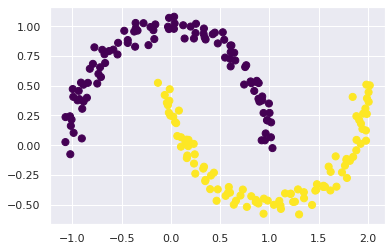

In [9]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2,
                           affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

SpectralClustering на самом деле тот же K-means, использующий тот же фокус, чтоб и SVR, - генерацию дополнительный нелинейно зависимых признаков, в данном случае спектральных. Пример выбора нужного алгоритма кластеризации отлично представлен вот здесь - https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

# K-means for handwritten digits clustering

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [11]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

Попробуем провести кластеризацию рукописных цифр методом к-средних. Для начала визуализируем центры кластеров. Как мы можем увидеть ниже, алгоритм смог распознать цифры, но могут быть проблемы с единицей и восьмеркой

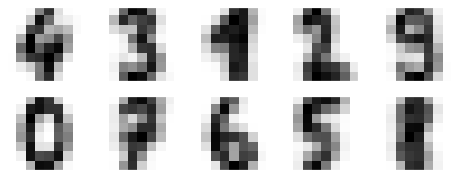

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [13]:
from scipy.stats import mode
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

Text(89.18, 0.5, 'predicted label')

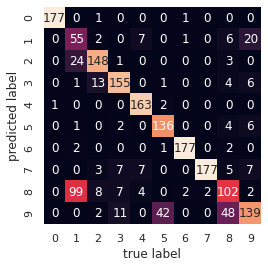

In [15]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

Как мы можем заметить, К-средних дал результат около 80% при попытке кластеризовать рукописные цифры без известных меток. Очевидно что модель путает цыфры 1 и 8 из-за того, что в рукописном виде 8 - часто становится слишком плоской. Если применить к этим же данным алгоритм TSNE, мы получим точность кластеризации 94%

In [16]:
from sklearn.manifold import TSNE
# Проекция данных: выполнение этого шага займет несколько секунд
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)
# Расчет кластеров
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)
# Перестановка меток местами
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
# Оценка точности
accuracy_score(digits.target, labels)

0.9398998330550918

Text(89.18, 0.5, 'predicted label')

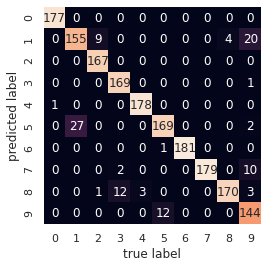

In [17]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

# K-means for colors compress

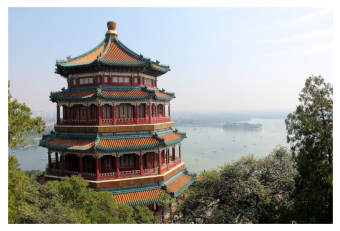

In [18]:
# Обратите внимание: для работы этого кода
# должен быть установлен пакет pillow
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

In [19]:
china.shape

(427, 640, 3)

In [20]:
data = china / 255.0 # используем шкалу 0...1
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

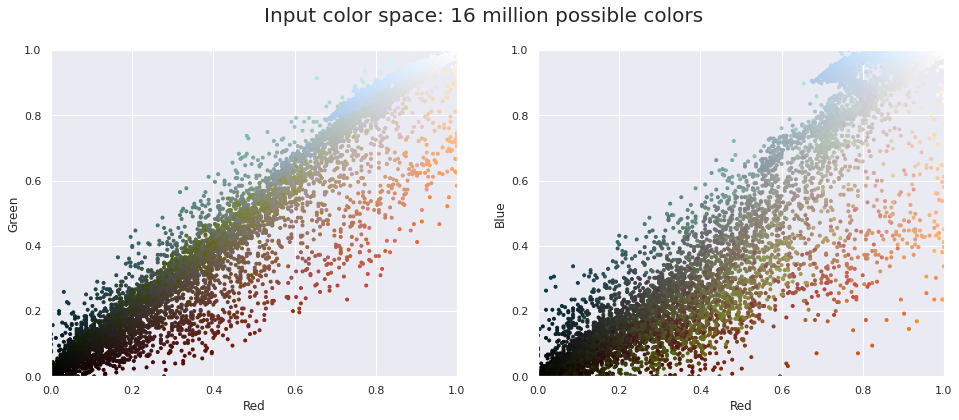

In [22]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    # Выбираем случайное подмножество
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    fig.suptitle(title, size=20)


plot_pixels(data, title='Input color space: 16 million possible colors') 
# Исходное цветовое пространство: 16 миллионов
# возможных цветов

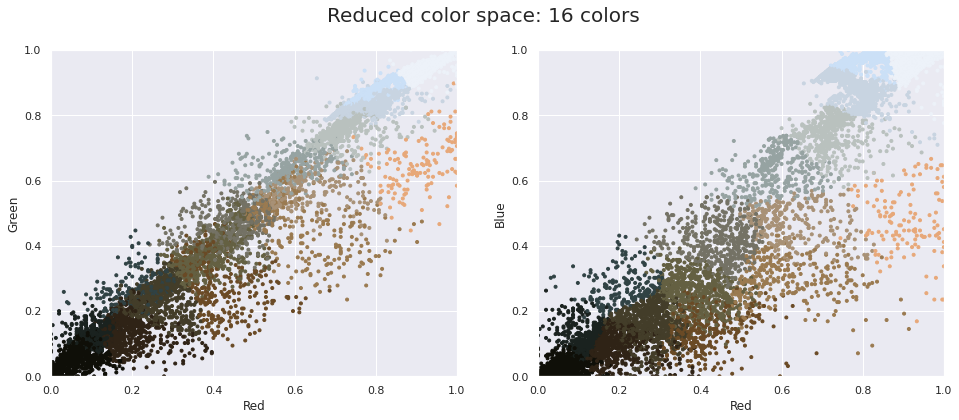

In [23]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")
# Редуцированное цветовое пространство: 16 цветов

Text(0.5, 1.0, '16-color Image')

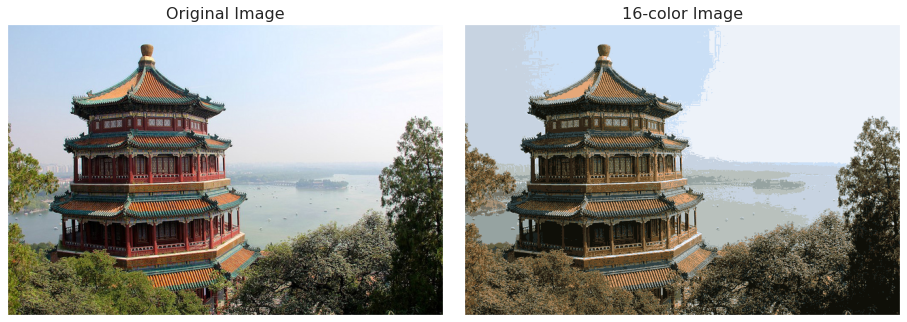

In [24]:
china_recolored = new_colors.reshape(china.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)  # Первоначальное изображение
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)  # 16-цветное изображение

MiniBatchKMeans является более оптимизированной версией метода KMeans для большого количества данных. Основная хитрость в том, чтоб использовать лишь подмножество данных для корректировки центров кластеров на каждом шаге. <br>
Как мы смогли увидеть из этого примера, можно сократить количество цветов в изображении методом кластеризации, чтоб позволит иметь куда меньшие вычислительные расходы в алгоритмах компьютерного зрения